In [18]:
import numpy as np
import matplotlib.pyplot as plt
import utils
import skimage
import SimpleITK as sitk

image_viewer = sitk.ImageViewer() 

#PARAMETERS

channel_letter = "G"
binary_color = "B"
path = "data/04_060__150_00_01_00C_230922_3D.tif"
threshold = 0.55


In [19]:
img_color = utils.read_image(path)
img_gray = utils.rgb_to_gray(img_color)

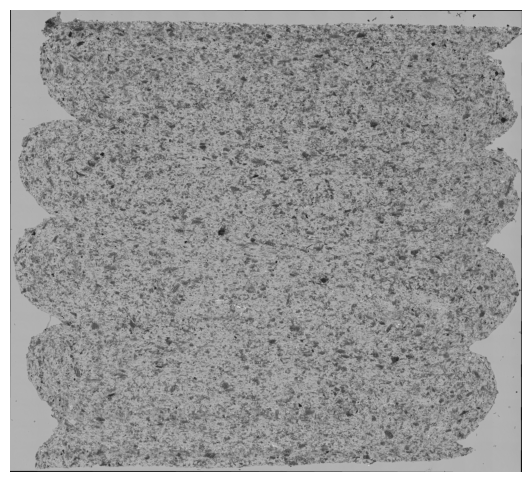

In [20]:
rgb_channels = {'R': 0, 'G': 1, 'B': 2}
hsv_channels = {'H': 0, 'S': 1, 'V': 2}
if channel_letter in rgb_channels:
    channel_num = rgb_channels[channel_letter]
    channel_image = img_color[:, :, channel_num]
elif channel_letter in hsv_channels:
    channel_num = hsv_channels[channel_letter]
    img_hsv = skimage.color.rgb2hsv(img_color)
    channel_image = img_hsv[:, :, channel_num]
else:
    print("Invalid channel letter provided")

if binary_color == "B":
    channel_binary = (channel_image < threshold).astype(np.uint16)
elif binary_color =="W":
    channel_binary = (channel_image > threshold).astype(np.uint16)
channel_binary = sitk.GetImageFromArray(channel_binary)

#Masks binary image to disregard black text from label
img_gray = sitk.GetImageFromArray(img_gray)
img_gray= sitk.RescaleIntensity(img_gray, 0, 255)
binary_mask = sitk.BinaryThreshold(img_gray, lowerThreshold=0, upperThreshold=25, insideValue=0, outsideValue=1)
mask_filter = sitk.MaskImageFilter()
channel_binary = mask_filter.Execute(channel_binary, binary_mask)

utils.print_image(channel_image)

In [21]:
#Closes image
close_filter = sitk.BinaryMorphologicalClosingImageFilter()
close_filter.SetKernelRadius([45, 45])
close_filter.SetForegroundValue(1)

closed_image = close_filter.Execute(channel_binary)

In [22]:
#Erodes image, given that we can afford to lose edge pixels in order to remove background
erode_filter = sitk.BinaryErodeImageFilter()
erode_filter.SetKernelRadius([60, 60])
erode_filter.SetForegroundValue(1)

eroded_image = erode_filter.Execute(closed_image)

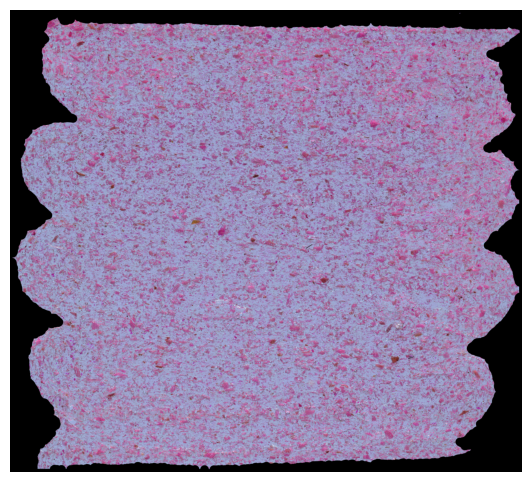

In [23]:
#Appllies a binary mask to the color image, removing background
color_image = sitk.GetImageFromArray(img_color, isVector=True)
mask_image = eroded_image

binary_mask = sitk.BinaryThreshold(mask_image, lowerThreshold=1, upperThreshold=255, insideValue=1, outsideValue=0)

mask_filter = sitk.MaskImageFilter()
mask_filter.SetMaskingValue(0)
masked_color_image = mask_filter.Execute(color_image, binary_mask)

utils.print_image(sitk.GetArrayViewFromImage(masked_color_image))